## Import Libraries

In [2]:
>>> import nltk
>>> nltk.download('stopwords')
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import model_selection,metrics,preprocessing
import torch
from torchtext import data
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import spacy
lang = spacy.load('en')
stemmer = PorterStemmer()
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import RandomOverSampler

stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Model   ",torch.cuda.get_device_name(0))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
GPU Model    Tesla T4


## Confusion Matrix Method

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Cleaning Data, Preprocessing

In [4]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=='Negative':
            y.values[i]=0.0
        else:
            y.values[i]=1.0
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

def target_arrange_b(y):
    
    for i in range(len(y)):
        if y.values[i]=='negative':
            y.values[i]=0.0
        else:
            y.values[i]=1.0
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

## Load Dataset and Process

In [ ]:
with open("All_Tickers.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

indexNames = X[X['Target'] == 'Neutral'].index
 
# Delete these row indexes from dataFrame
X.drop(indexNames , inplace=True)


X=X.sort_values("Date")

print("Number of Examples : ",len(X),"\n")
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n******************\n")

X['Target']=target_arrange(X['Target'])
X=X.drop('Date',1)

print("Negative Examples : ",(X['Target']==0).sum())
print("Positive Examples : ",(X['Target']==1).sum())


Number of Examples :  52853 

Number of Examples after removing duplicates:  42271 

Number of words before cleaning :  1443775
Number of words after cleaning :  941674

******************

Negative Examples :  18466
Positive Examples :  23805


## Stemming

In [ ]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])
print(X['Article'])
Xv = X['Article'].to_frame()

0        actual econom impact coronaviru may wors data ...
1        futur tumbl start second quarter coronaviru cr...
2        compani cut job worst coronaviru shutdown hit ...
3        china economi may grow year happen year china ...
4        adp privat compani cut employe period march cn...
                               ...                        
42266    huya stock buy compani well posit long term gr...
42267    baidu iqiyi short seller headach final iqiyi r...
42268    alaska air pois lead airlin recoveri low cash ...
42269    car vend machin sell vehicl price around car v...
42270    best long term stock buy novemb long term inve...
Name: Article, Length: 42271, dtype: object


## Oversampling and Csvs

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(Xv,X['Target'], test_size=0.2,stratify=X['Target'])

ros = RandomOverSampler()
X_train,y_train = ros.fit_resample(X_train, y_train)

train1=pd.DataFrame(columns=['Article','Target'])
val = pd.DataFrame(columns=['Article','Target'])

df = pd.DataFrame(data = X_train,columns=['Article'])
df1= pd.DataFrame(data = y_train,columns=['Target'])
train1['Article']=df['Article']
train1['Target']=df1['Target']

df = pd.DataFrame(data = X_val,columns=['Article'])
df1= pd.DataFrame(data = y_val,columns=['Target'])
val['Article']=df['Article']
val['Target']=df1['Target']

print("Negative Examples in Training after OverSampling: ",(train1['Target']==0).sum())
print("Positive Examples in Training after OverSampling: ",(train1['Target']==1).sum())

train1.to_csv (r'Train.csv', index = False, header=True)
val.to_csv (r'Val.csv', index = False, header=True)




Negative Examples in Training after OverSampling:  19044
Positive Examples in Training after OverSampling:  19044


## Process Tweets as TestSet

In [ ]:
Test_pd = pd.read_csv(r'all-data.csv',sep=",",skiprows=0,header=None,encoding="latin-1")


X_Tweets= pd.DataFrame(columns=['Article','Target'])
X_Tweets['Article']=Test_pd[Test_pd.columns[1]]
X_Tweets['Target']=Test_pd[Test_pd.columns[0]]

indexNames = X_Tweets[X_Tweets['Target'] == 'neutral'].index
# Delete these row indexes from dataFrame
X_Tweets.drop(indexNames , inplace=True)
X_Tweets.drop_duplicates(inplace=True)
X_Tweets.index = range(len(X_Tweets))

X_Tweets['Article']=clean_data(X_Tweets['Article'])
X_Tweets['Target']=target_arrange_b(X_Tweets['Target'])

X_Tweets['Article']= X_Tweets['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X_Tweets['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X_Tweets['Article'][i] = ' '.join(X_Tweets['Article'][i])
print(X_Tweets['Article'])
#X_Tweets['Article'] = X_Tweets['Article'].to_frame()
X_Tweets.to_csv (r'Test.csv', index = False, header=True)



0       intern electron industri compani elcoteq laid ...
1       new product plant compani would increas capac ...
2       accord compani updat strategi year baswar targ...
3       financ aspocomp growth aspocomp aggress pursu ...
4       last quarter componenta net sale doubl eurm eu...
                              ...                        
1962    helsinki thomson financi share cargotec fell s...
1963    london marketwatch share price end lower londo...
1964    oper profit fell eur eur includ vessel sale ga...
1965    net sale paper segment decreas eur second quar...
1966    sale finland decreas januari sale outsid finla...
Name: Article, Length: 1967, dtype: object


## Build Vocabulary

In [5]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

#TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
TEXT = data.Field(batch_first=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

fields = [('text',TEXT),('label', LABEL)]
X_train=data.TabularDataset(path = 'Train.csv',format = 'csv',fields = fields,skip_header = True)
X_val=data.TabularDataset(path = 'Val.csv',format = 'csv',fields = fields,skip_header = True)
X_test=data.TabularDataset(path = 'Test.csv',format = 'csv',fields = fields,skip_header = True)

TEXT.build_vocab(X_train)  
LABEL.build_vocab(X_train)

print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  


Size of TEXT vocabulary: 19601
Size of LABEL vocabulary: 2
[('stock', 21341), ('earn', 12533), ('report', 8623), ('market', 7619), ('compani', 6016), ('expect', 4810), ('share', 4638), ('investor', 4548), ('trade', 4521), ('coronaviru', 4455)]


## Accuracy, Loss and Optimizer Function

In [6]:
def find_accuracy(preds, y):
    real_values=torch.sigmoid(preds)
    temp = torch.round(real_values)
    valid = (temp == y).float() 
    accur = valid.sum() / len(valid)
    return accur,temp,y,real_values

def Loss_Optimizer (model,valueLR):
    criterion = nn.BCEWithLogitsLoss()
    #criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=valueLR)
    return optimizer,criterion

## Training and Testing Functions 

In [7]:
def train(model,data,lr,optimizer,criterion):
        
    model.train()
    sumloss=0.0
    sumacc=0.0
    for i in data:
        text = i.text   
        optimizer.zero_grad()
        pred = model(text).squeeze(1)    
        loss = criterion(pred, i.label)
        acc,_,_,_ = find_accuracy(pred, i.label)
        loss.backward()
        optimizer.step()
        sumloss += loss.item()
        sumacc += acc.item()
          
    return sumloss / len(data), sumacc / len(data)

def test(model, data, criterion):
    y_pred_list = []
    y_true_list = []
    real_v_list = []
    sumloss = 0
    sumacc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for i in data:
            text = i.text
            
            pred = model(text).squeeze(1)
           
            loss = criterion(pred, i.label)
            
            acc,y_pred_tags,y_true,real_v = find_accuracy(pred, i.label)

            sumloss += loss.item()
            sumacc += acc.item()
            y_pred_list.append(y_pred_tags.cpu().numpy())
            y_true_list.append(y_true.cpu().numpy())
            real_v_list+=real_v.flatten().tolist()
        
    return sumloss / len(data), sumacc / len(data),y_pred_list,y_true_list,real_v_list

def process_test(model,numEpochs,data_tr,data_val,data_test,lr,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,_,_ ,_= test(model, data_val, criterion)
        
        if i==0:
            max=valid_acc
            torch.save(model.state_dict(), best_model)
        elif valid_acc > max:
            max = valid_acc
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list, real_v_list= test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1])
    np.set_printoptions(precision=3)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, with normalization')
     
    return real_v_list

def process_test2(model,numEpochs,data_tr,data_val,data_test,lr,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
        
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,_,_,_ = test(model, data_val, criterion)
        
        if i==0:
            minloss=valid_loss
            torch.save(model.state_dict(), best_model)
        elif valid_loss < minloss:
            minloss = valid_loss
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list, real_v_list= test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1])
    np.set_printoptions(precision=3)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, with normalization')
    return real_v_list

## RNN Models

In [8]:
class myLSTM(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.LSTM(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text):
                
        embedded = self.dropout(self.embedding(input_text))
       
        rnn_out,(rnn_hid,rnn_cell) = self.rnn(embedded)
        hidden = self.dropout(torch.cat((rnn_hid[-2,:,:], rnn_hid[-1,:,:]), dim=1))
        out=self.fc(hidden.squeeze(0))
        return out

class myGRU(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.GRU(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text):
                
        embedded = self.dropout(self.embedding(input_text))
        
        rnn_out,hidden = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        out=self.fc(hidden.squeeze(0))
        return out

In [18]:
myInput = len(TEXT.vocab)
myEmbed = 300
myHid = 256
myOut = 1
batch=16
train_it, val_it, test_it = data.BucketIterator.splits((X_train, X_val, X_test),sort_key = lambda x: len(x.text),
    sort_within_batch=True,batch_size = batch,device = device)  
dropout = 0.5

new_model2 = myLSTM(myInput, myEmbed, myHid, myOut,dropout)
new_model2.to(torch.device(device))
new_model3 = myGRU(myInput, myEmbed, myHid, myOut,dropout)
new_model3.to(torch.device(device))

print(new_model2)
print(new_model3)
#torch.save(new_model2.state_dict(), 'model_LSTM_1.pt')

myLSTM(
  (embedding): Embedding(19601, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
myGRU(
  (embedding): Embedding(19601, 300)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## LSTM results

Epoch :  5  Train Loss :  0.14722025763976448   Train Acc :  0.942854892902142   Valid Loss :  0.3089107113181955  Val Acc :  0.9111531190926276
Epoch :  10  Train Loss :  0.09909863301927796   Train Acc :  0.9629882402351952   Valid Loss :  0.3695222142822509  Val Acc :  0.9109168241965974
Epoch :  15  Train Loss :  0.07567511334776844   Train Acc :  0.9708368332633347   Valid Loss :  0.4034970766989165  Val Acc :  0.9129253308128544
Epoch :  20  Train Loss :  0.06390185387175748   Train Acc :  0.9762967240655187   Valid Loss :  0.5303078197684373  Val Acc :  0.9090264650283554

Time needed for Training :  8.658550651868184

Loss in Testset :  0.6292125844373936   Accuracy in Testset :  0.8012195127766307 

Normalized confusion matrix
[[0.796 0.204]
 [0.197 0.803]]


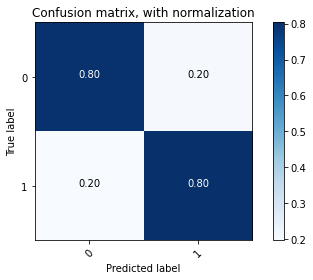

In [19]:
lstm_list=process_test(new_model2,20,train_it,val_it,test_it,0.001,"LSTM_tweets.pt")

## GRU results

Epoch :  5  Train Loss :  0.16228030432846455   Train Acc :  0.9375   Valid Loss :  0.24893628249855074  Val Acc :  0.9133641643199668
Epoch :  10  Train Loss :  0.12647401621866994   Train Acc :  0.9527771944561109   Valid Loss :  0.2864128629983331  Val Acc :  0.9139549015600424
Epoch :  15  Train Loss :  0.11807712041483452   Train Acc :  0.9561896262074758   Valid Loss :  0.3079427500226357  Val Acc :  0.9100897920604915
Epoch :  20  Train Loss :  0.11535943213743477   Train Acc :  0.9577120957580848   Valid Loss :  0.2972861278839788  Val Acc :  0.9125708884688091

Time needed for Training :  8.044550589720409

Loss in Testset :  0.6423524741265105   Accuracy in Testset :  0.7737466125953488 

Normalized confusion matrix
[[0.791 0.209]
 [0.234 0.766]]


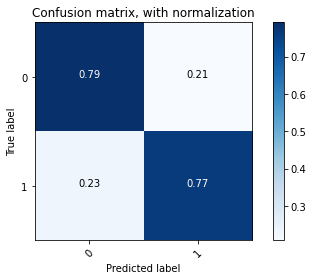

In [20]:
gru_list=process_test(new_model3,20,train_it,val_it,test_it,0.001,"GRU_tweets.pt")